# Recovering Risk-Neutral Probabilities from Options Prices

It's intuitive that the price of call and put options imply that the market sees probabilities for different "states of the world" or different prices of the underlying security at expiration of the option. If a future price of a stock (say, Apple) is very likely, then an option that provides a high payoff for that future price will be relatively expensive. If the price of a future that provides a high payoff for a given option is low, the price of the option will be relatively low. 

## Problem description


<b>What we have:

- Call and put options for a given security each with:
    - Option price
    - Strike price
    - Expiration date
    - Different potential prices for the underlying asset ("states of the world"), bounded by $[a,b]$

<b>What we want:
- The implied probability distribution for future potential prices of the underlying asset at the expiration date
    
<b>Assumption:
- Risk-neutrality: an investor is risk-neutral (as opposed to risk-averse) if, for example, they are indifferent to an instrument that pays a guaranteed 3 dollar return and one that pays 0 dollars 50% of the time and 6 dollars 50% of the time.

## Problem formulation

# min $\sum_k (C_k - C_k(x))^2 + \sum_k (P_k - P_k(x))^2$

where
- $C_k$, $P_k$ are the true prices of the call and put options respectively options for each available strike price $k$
- $C_k(x)$, $P_k(x)$ can be thought of as the theoretical prices for the options

Essentially, we are solving a constrained least-squares problem.

For a case where states of the world $\Omega$ are continuous and $a \le \omega \le b$, 

$C_k(x) = \frac{1}{1+r} \int_a^b{p(\omega)S_1(\omega)d\omega}$,   |    $P_k(x) = \frac{1}{1+r} \int_a^b{p(\omega)S_1(\omega)  d\omega}$

For the discrete case (which will be our encoding of the problem):

$C_k(x) = \frac{1}{1+r} \Sigma_a^b{p(\omega)S_1(\omega)d\omega}$,   |    $P_k(x) = \frac{1}{1+r} \Sigma_a^b{p(\omega)S_1(\omega)  d\omega}$

In other words, the theoretical price of the option is the sum of all probabilities of a state of the world occurring times the payoff if that state occurs, discounted by the risk-free rate. We constrain that all probabilities for all states of the world sum to 1.

So, we must find the probability for each potential future price of the underlying asset between $a$ and $b$. This probability is "priced in" to the price $C_k$ and $P_k$ of each call and put option; so, the expected value of each option with strike price $k$ (the value of the option, as calculated by the dot product of the payoff vector and probability vector for $\Omega$), minus the cost of the option *should* be zero, assuming no arbitrage opportunity exists. 

## Solving the problem using quantum techniques

In [1]:
import qubovert as qv
import sympy
from qubovert.sim import anneal_qubo
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import matplotlib.pyplot as plt
import numpy as np
from optionshelper import *

In [2]:
# Set the risk-free rate
r = 0.03
R = 1 + r

Let's find the probability distribution for AAPL's price one Friday from now.

In [3]:
# Get sample options data
json_data = get_options_data_as_json()

As we said, we're going to need the prices of the options, their corresponding strike prices, and expiration date, so let's get those.

In [4]:
C_k = [] # Current mkt price of call options
P_k = [] # Current mkt price of put options

C = [] # Strike prices for call options
P = [] # Strike prices for put options

In [5]:
index_in_json_data = 0 # Toggle this to shift the desired expiration date later
for contract in json_data['data'][index_in_json_data]['options']['CALL']:
    C_k.append(contract['lastPrice'])
    C.append(contract['strike'])
    
for contract in json_data['data'][index_in_json_data]['options']['PUT']:
    P_k.append(contract['lastPrice'])
    P.append(contract['strike'])
    
current_price = json_data['lastTradePrice']
expiration_date = json_data['data'][index_in_json_data]['options']['CALL'][0]['expirationDate']
print(f"Expiration date for options: {expiration_date}")
print(f"Current price of underlying asset: {current_price}")

Expiration date for options: 2022-10-21
Current price of underlying asset: 143.86


We also need to define what our bounds for the price of AAPL at expiration. Since the default expiration for this notebook is in the near future, a range of plus or minus 15% of the current value is a reasonable boundary.

In [6]:
# Create different states of the world
max_gain_loss = 0.15 # The max percent increase/decrease that we believe is possible until expiration
interval_between_states = 1 # The dollar interval for our model (e.g. interval_between_states = 0.5 means that possible states of the world occur at every 50 cents between the upper and lower price)

omega = []
upper_price = int(current_price * (1+max_gain_loss))
lower_price = int(current_price * (1-max_gain_loss))
price = lower_price
while price <= upper_price:
    omega.append(price)
    price += interval_between_states

In [7]:
coarseness = 7 # Factor to discretize probabilities
x = create_binary_variables(coarseness, omega)

In [8]:
obj = create_objective_function(C, C_k, P, P_k, x, coarseness, omega, R)

100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


In [9]:
# Constrain the probabilities to sum to 1
lam = sympy.Symbol("lam")
const = generate_sum_to_one_constraint(x)
obj.add_constraint_eq_zero(const, lam=lam)
print("Constraint added.")

Constraint added.


In [10]:
# Enforce the constraint
M = 1
obj_new = obj.subs({lam : M})
len(obj.variables)

308

In [11]:
# Solve
%time res = anneal_qubo(obj_new, num_anneals=100)
solution = res.best.state

Wall time: 12 s


In [12]:
# Check that the probabilities sum to 1
probabilities = {}
for state in omega:
    probabilities[state] = 0
for sol in solution:
    if solution[sol] == 1:
        s, power = int(sol.split("_")[1]), int(sol.split("_")[2])
        state = omega[s]
        probabilities[state] += 1/(2**(power+1))

# If probabilities don't sum to 1, normalize them
prob_sum = sum(probabilities.values())
print(prob_sum)
for state in probabilities:
    probabilities[state] = probabilities[state] / prob_sum

print(obj_new.value(solution))

1.03125
4017.8977611329174


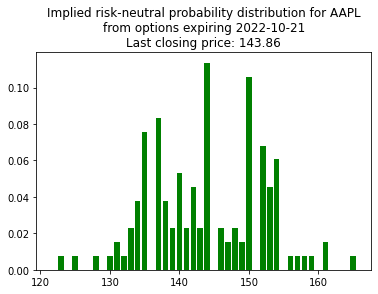

In [13]:
plt.bar(list(probabilities.keys()), probabilities.values(), color='g')
plt.title(f"Implied risk-neutral probability distribution for {json_data['code']}\nfrom options expiring {expiration_date}\nLast closing price: {current_price}")
plt.show()

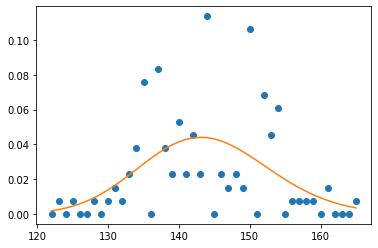

In [14]:
def f(x, mu, sigma) :
    return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)- mu)**2)/(2*sigma**2))
x = np.array([i for i in probabilities.keys()])
y = np.array([i for i in probabilities.values()])

params, extras = curve_fit(f, x, y)
plt.plot(x, y, "o")
plt.plot(x, f(x ,params[0], params[1])) 

plt.show()

In [15]:
print("Area under orange curve (should equal ~1):", round(trapz(f(x, params[0], params[1]), x), 2))

Area under orange curve (should equal ~1): 0.98


In [16]:
# Find the probability that the future price is betweeen two other points from the curve we fitted
get_probability_between_prices_curve(params, 100, 130)

0.044

In [17]:
# Find the probability that the future price is betweeen two other points from solution from the quantum results
get_probability_between_prices_from_qubo(probabilities, 100, 130)

0.030303030303030304

## Conclusions

We have shown how to extract implied risk-neutral probabilities for the price of an underlying asset at expiration using quantum techniques.

References:

[Inspiration for this notebook in Section 8.4](https://www.andrew.cmu.edu/user/gc0v/webpub/book.pdf)

[Morgan Stanley Illustration of the Problem](https://www.morganstanley.com/content/dam/msdotcom/en/assets/pdfs/Options_Probabilities_Exhibit_Link.pdf)